In [20]:
import pandas as pd
import numpy as np
from os import listdir
from configuration import get_config
from association import compute_iou

IMG_PATH = r"C:/javier/personal_projects/computer_vision/data/KITTI_object_tracking/images/training/image_02/0000/"
DET_FILE = r"C:/javier/personal_projects/computer_vision/data/KITTI_object_tracking/detections_regionlet/training/det_02/0000.txt"
DATASET = 'KITTI'

In [33]:
# load dets
config = get_config(DATASET)
dets = pd.read_csv(DET_FILE, header=None, sep=" ")
dets.columns = config['det_cols']

# filter dets with low score
min_score = -1.0
dets = dets[dets['score'] > min_score]

In [ ]:
# sort by score
dets = dets.sort_values(by='score', ascending=False).reset_index(drop=True)

iou_thr = 0.2
picked_dets_indexes = []
frames = dets['frame'].unique()
for i, frame in enumerate(frames):
    suppress_index = []
    cur_dets = dets.loc[dets['frame'] == frame, :]
    cur_indexes = list(cur_dets.index)
    for j in cur_indexes:   # already sorted by score
        if j in suppress_index:
            continue
        picked_dets_indexes.append(j)
        box_ref = np.array([cur_dets.loc[j, 'top'], cur_dets.loc[j, 'left'], cur_dets.loc[j, 'bottom'], cur_dets.loc[j, 'right']])
        for k in cur_indexes[j+1:]:
            box_test = np.array([cur_dets.loc[k, 'top'], cur_dets.loc[k, 'left'], cur_dets.loc[k, 'bottom'], cur_dets.loc[k, 'right']])
            iou = compute_iou(box_ref, box_test)
            if iou > iou_thr:
                suppress_index.append(k)

nms_dets = dets.loc[picked_dets_indexes, :]

nms_dets.to_csv('0000_nms_dets.csv', sep=" ", index=False, header=False)

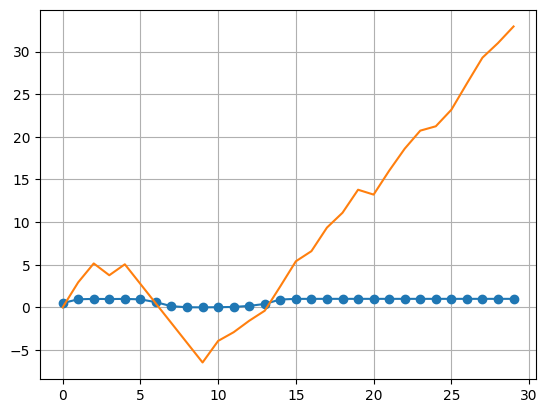

In [50]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
# exploration track score
z_dim = 2
n = 30
hit_vector = np.ones(n)
x_real, y_real = 2.0, 3.0

hit_vector[5:10] = 0

x_noise = x_real + np.sqrt(1.2)*np.random.randn(n)
y_noise = y_real + np.sqrt(0.9)*np.random.randn(n)

S = np.array([[1.2, 0], [0, 0.9]])

Pd = 0.9
Bft = 0.1/100
llr = np.zeros_like(x_noise) # l0 0.5 prob
for i, hit in enumerate(hit_vector):
    if i > 0:
        if hit > 0:
            y = np.array([x_noise[i] - x_real, y_noise[i] - y_real]).reshape(-1, 1)
            dsq = y.T @ np.linalg.inv(S) @ y
            llr[i] = llr[i-1] + np.log(Pd/((2*np.pi)**(z_dim) * Bft * np.sqrt(np.linalg.det(S)))) - dsq/2
        else:
            llr[i] = llr[i-1] + np.log(1-Pd)

prob = np.exp(llr)/(1 + np.exp(llr))

fig, ax = plt.subplots()
ax.plot(prob, '-o')
ax.plot(llr)
ax.grid()


In [51]:
np.log(1-Pd)

-2.302585092994046

In [47]:
hit_vector

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# TRACKER_NAME = 'customSORT_pa_lowr_exfov'
TRK1_NAME = 'customSORT_v1_newDeletion'
TRK2_NAME = 'customSORT'
RESULTS_FOLDER = f'data/tracks'
CLASS = "pedestrian"   # car, pedestrian
COLS = ['HOTA', 'MOTA', 'IDSW', 'IDTP', 'IDFN', 'IDFP', 'DetA', 'AssA', 'DetRe', 'DetPr', 'AssRe', 'AssPr', 'Dets', 'GT_Dets', 'IDs', 'GT_IDs']

class_ = "car"
cols_detailed = ['seq', 'HOTA___AUC', 'IDSW', 'Frag', 'GT_IDs']
res_1 = pd.read_csv(f'{RESULTS_FOLDER}/{TRK1_NAME}/{class_}_detailed.csv', sep=",")
res_2 = pd.read_csv(f'{RESULTS_FOLDER}/{TRK2_NAME}/{class_}_detailed.csv', sep=",")
res_1 = res_1.loc[res_1["seq"]=="COMBINED", :].reset_index()
res_2 = res_2.loc[res_2["seq"]=="COMBINED", :].reset_index()

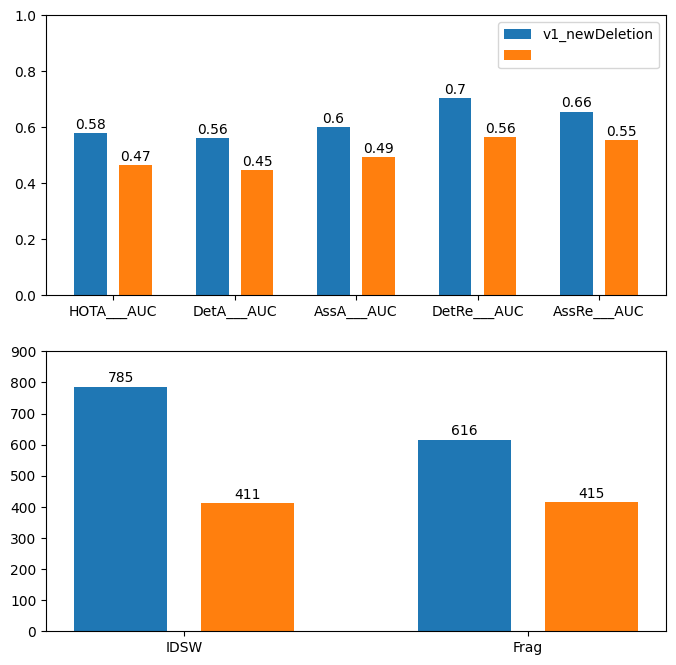

In [94]:
get_trk_suffix = lambda x: "_".join(x.split("_")[1:])

def autolabel(rects, as_int = False):
    for rect in rects:
        h = rect.get_height()
        h_viz = str(int(h)) if as_int else str(round(h, 2))
        ax.text(rect.get_x()+rect.get_width()/2., 1.01*h, h_viz,
                ha='center', va='bottom')
        
def plot_comparison_bars(ax, res_1, res_2, metrics, bar_width):
    bar_ind = np.arange(len(metrics))
    bar_offset = bar_width + 0.1
    rects1 = ax.bar(bar_ind, list(res_1.loc[0, metrics].values), bar_width)
    rects2 = ax.bar(bar_ind + bar_offset, list(res_2.loc[0, metrics].values), bar_width)
    ax.set_xticks(bar_ind + bar_offset/2)
    ax.set_xticklabels(metrics)
    return rects1, rects2

overall_metrics = ["HOTA___AUC", "DetA___AUC", "AssA___AUC", "DetRe___AUC", "AssRe___AUC"]
absolute_metrics= ["IDSW", "Frag"]
metrics = overall_metrics
bar_width = 0.27 

plot_config = [
    {"metrics": overall_metrics, "as_int": False, "top": 1},
    {"metrics": absolute_metrics, "as_int": True, "top": 900},
]

fig, axes = plt.subplots(figsize=(8, 8), nrows=2)
for i, pconf in enumerate(plot_config):
    ax = axes[i]
    metrics = pconf["metrics"]
    r1, r2 = plot_comparison_bars(ax, res_1, res_2, pconf["metrics"], bar_width)
    if i == 0:
        ax.legend((r1[0], r2[0]), (get_trk_suffix(TRK1_NAME), get_trk_suffix(TRK2_NAME)))
    ax.set_ylim(top = pconf["top"])
    autolabel(r1, pconf["as_int"])
    autolabel(r2, pconf["as_int"])

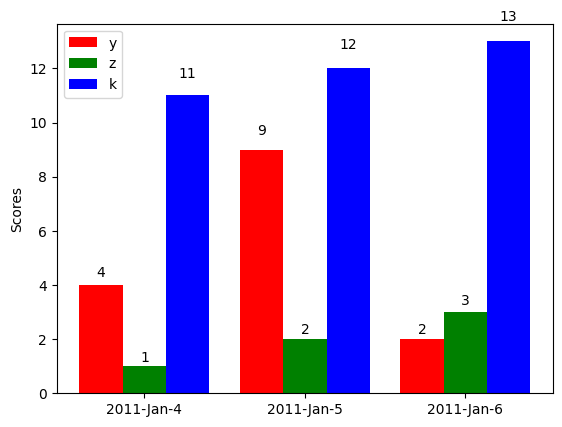

In [7]:
import numpy as np
import matplotlib.pyplot as plt

N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)

yvals = [4, 9, 2]
rects1 = ax.bar(ind, yvals, width, color='r')
zvals = [1,2,3]
rects2 = ax.bar(ind+width, zvals, width, color='g')
kvals = [11,12,13]
rects3 = ax.bar(ind+width*2, kvals, width, color='b')

ax.set_ylabel('Scores')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('2011-Jan-4', '2011-Jan-5', '2011-Jan-6') )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('y', 'z', 'k') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
